In [1]:
import torch
import torch.nn as nn
import torchvision
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
import pandas as pd
from collections import defaultdict
import os
import PIL
from scipy.io import wavfile
import torchaudio
from IPython.display import Audio, display

In [2]:
dev = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [4]:
!mkdir .kaggle
!mv kaggle.json .kaggle/
!mv .kaggle ~/

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Proyecto 1: Clasificación de Imagenes

De la página [kaggle](https://www.kaggle.com/), descarguen una dataset de clasificación de imagenes. Por ejemplo:
- [dogs and cats dataset](https://www.kaggle.com/chetankv/dogs-cats-images).
- [flowers](https://www.kaggle.com/alxmamaev/flowers-recognition) 
- [pokemon](https://www.kaggle.com/lantian773030/pokemonclassification)
- [American Sign Language](https://www.kaggle.com/grassknoted/asl-alphabet)
- [Rock, Paper, Scissors](https://www.kaggle.com/drgfreeman/rockpaperscissors)

Pueden usar otras plataformas para buscar y descargar los datastes (como google dataset), o tambien pueden crear su propio dataset de las cosas que quisieran classificar (alrededor de 20~50 imagenes por clases estaria bien).

Es necesario que la carpeta que contiene a las imagenes tenga el siguiente formato:
```
dataset/
 clase1/
  puede_haber_subcarpetas/
    imagen1.jpg
    imgen2.jpg
 clase2/
  solo_las_imagenes.jpg
 clase3/
 ....
```

## Reporte

Diseñen una red neuronal para que clasifique las imagenes que se descargaron.

**Explicar el tipo de dataset que se esta utilizando**

In [5]:
# TODO: Modificar esto acorde al dataset que se va a usar
!kaggle datasets download chetankv/dogs-cats-images
!unzip dogs-cats-images.zip

Se han truncado las últimas 5000 líneas del flujo de salida.
  inflating: dog vs cat/dataset/training_set/cats/cat.37.jpg  
  inflating: dog vs cat/dataset/training_set/cats/cat.370.jpg  
  inflating: dog vs cat/dataset/training_set/cats/cat.3700.jpg  
  inflating: dog vs cat/dataset/training_set/cats/cat.3701.jpg  
  inflating: dog vs cat/dataset/training_set/cats/cat.3702.jpg  
  inflating: dog vs cat/dataset/training_set/cats/cat.3703.jpg  
  inflating: dog vs cat/dataset/training_set/cats/cat.3704.jpg  
  inflating: dog vs cat/dataset/training_set/cats/cat.3705.jpg  
  inflating: dog vs cat/dataset/training_set/cats/cat.3706.jpg  
  inflating: dog vs cat/dataset/training_set/cats/cat.3707.jpg  
  inflating: dog vs cat/dataset/training_set/cats/cat.3708.jpg  
  inflating: dog vs cat/dataset/training_set/cats/cat.3709.jpg  
  inflating: dog vs cat/dataset/training_set/cats/cat.371.jpg  
  inflating: dog vs cat/dataset/training_set/cats/cat.3710.jpg  
  inflating: dog vs cat/dataset/t

Se está utilizando el dataset de perros y gatos

**Si se modifica algo en la celda inferior explicar que cambios se hizo**

In [6]:
# Esto no se necesita modificar. Son las funciones para entrenar el modelo.
# OPTIONAL:
# Si se desea se puede modificar para por ejemplo almacenar el accuracy y el loss de cada epoca para poder plotearlo luego
def evaluate(model, loader, crit):
  model.eval()
  total = 0
  corrects = 0
  avg_loss = 0
  for x, y in loader:
    x = x.to(dev)
    y = y.to(dev)
    o = model(x)
    loss = crit(o,y)
    avg_loss += loss.item()
    corrects += torch.sum(torch.argmax(o,axis=1) == y).item()
    total += len(y)
  acc = 100* corrects / total
  avg_loss /= len(loader)  
  return avg_loss, acc

def train_one_epoch(model, train_loader, crit, optim):
  model.train()
  total = 0
  corrects = 0
  avg_loss = 0
  for x, y in train_loader:
    optim.zero_grad()
    x = x.to(dev)
    y = y.to(dev)
    o = model(x)
    loss = crit(o,y)
    avg_loss += loss.item()
    loss.backward()
    optim.step()
    corrects += torch.sum(torch.argmax(o,axis=1) == y).item()
    total += len(y)
  acc = 100 * corrects / total
  avg_loss /= len(train_loader)
  return avg_loss, acc

def train(model, train_loader, test_loader, crit, optim, epochs = 20):
  for epoch in range(epochs):
    train_loss, train_acc = train_one_epoch(model, train_loader,crit, optim)
    test_loss, test_acc = evaluate(model, test_loader, crit)
    print(f"epoch: {epoch}, train loss: {train_loss}, train acc: {train_acc}%, test loss: {test_loss}, test acc: {test_acc}%")

**Si se modifica algo en la celda inferior explicar que cambios se hizo**

In [7]:
# Esto tampoco se necesita modificar.
# OPTIONAL:
# Se puede aumentar más transformaciones (data augmentation) o cambiar el tamaño del resizing.
img_transform = torchvision.transforms.Compose([
  torchvision.transforms.Resize((128,128)),
  torchvision.transforms.CenterCrop(128),
  torchvision.transforms.RandomHorizontalFlip(p=0.5),
  torchvision.transforms.RandomRotation(degrees = 10),
  torchvision.transforms.ToTensor(),
])

Se usaron las transformaciones CenterCrop() que recorta la imagen dada en el centro, RandomHorizontalFlip() que voltea horizontalmente la imagen dada al azar con una probabilidad dada y RandomRotation() que rota la imagen dado un ángulo.

**Si se modifica algo en la celda inferior explicar que cambios se hizo**

In [8]:
# TODO: Modificar el path en donde se encuentrar sus imagenes de training y testing
train_ds = torchvision.datasets.ImageFolder("/content/dataset/training_set",transform=img_transform)
test_ds = torchvision.datasets.ImageFolder("/content/dataset/test_set",transform=img_transform)

Se reemplazó por el path de entrenamiento y test del dataset de perros y gatos

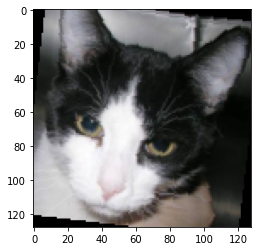

In [9]:
# Esto es solo para poder ver un ejemplo de las imagenes que se estan usando
plt.imshow(train_ds[18][0].numpy().transpose(1,2,0))

In [10]:
# Esto no se necesita modificar al menos que se quiera utilizar un batch size diferente
# OPTIONAL:
# Cambiar la opción de shuffle a False y observar que pasa con los input y targets que nos brinda el dataloader, que diferencias hay?
# Observar que pasa con el accuracy cuando no se realiza el shuffling y explicar porque.

train_dl = torch.utils.data.DataLoader(train_ds,batch_size=128,shuffle=True)
test_dl = torch.utils.data.DataLoader(test_ds,batch_size=128,shuffle=True)

**Defina su modelo**

In [11]:
# TODO: Definir el modelo
model = nn.Sequential(

    nn.Conv2d(3,16,7,bias = False),
    nn.BatchNorm2d(16),
    nn.ReLU(inplace=True),
    nn.MaxPool2d(2),
    nn.Conv2d(16,32,3,bias = False),
    nn.BatchNorm2d(32),
    nn.ReLU(inplace=True),
    nn.MaxPool2d(2),
    nn.Conv2d(32,32,5,bias = False),
    nn.BatchNorm2d(32),
    nn.ReLU(inplace=True),
    nn.MaxPool2d(2),
    nn.Conv2d(32,64,3,bias = False),
    nn.BatchNorm2d(64),
    nn.ReLU(inplace=True),
    nn.MaxPool2d(2),
    

    nn.Flatten(),
    nn.Linear(1600,512),
    nn.ReLU(inplace=True),
    torch.nn.Sigmoid(),
    nn.Linear(512,256),
    nn.ReLU(inplace=True),
    nn.Linear(256,128),
    nn.ReLU(inplace=True),
    nn.Linear(128,2),

).to(dev)

**Si se modifica algo en la celda inferior explicar que cambios se hizo**

Se cambió el número de epocas por 20

In [13]:
# Esto tampoco se necesita modificar
# OPTIONAL:
# Se puede aumentar o disminuir el learning rate para observar como es la evolucion de los accuracy y loss.

crit = nn.CrossEntropyLoss()
optim = torch.optim.SGD(model.parameters(),lr=0.1)
train(model,train_dl, test_dl, crit, optim, epochs=20)

epoch: 0, train loss: 0.3327128392836404, train acc: 85.35%, test loss: 1.07756033167243, test acc: 59.65%
epoch: 1, train loss: 0.314913268363665, train acc: 86.9875%, test loss: 0.6493538916110992, test acc: 72.65%
epoch: 2, train loss: 0.30539775888125104, train acc: 86.725%, test loss: 0.866319727152586, test acc: 64.35%
epoch: 3, train loss: 0.30368527722737143, train acc: 86.7125%, test loss: 0.49537426978349686, test acc: 78.35%
epoch: 4, train loss: 0.303080716539943, train acc: 87.375%, test loss: 0.5955839306116104, test acc: 70.95%
epoch: 5, train loss: 0.2813673551593508, train acc: 88.0375%, test loss: 0.9917022809386253, test acc: 63.7%
epoch: 6, train loss: 0.28540942545921083, train acc: 87.8%, test loss: 0.44833173230290413, test acc: 80.05%
epoch: 7, train loss: 0.2834727643501191, train acc: 88.0625%, test loss: 0.572965782135725, test acc: 74.95%
epoch: 8, train loss: 0.261393912964397, train acc: 88.8625%, test loss: 0.35347229056060314, test acc: 85.25%
epoch: 9, 

perro


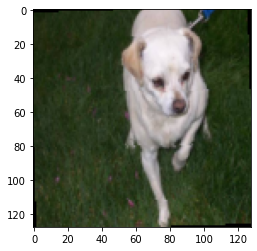

In [24]:
model.eval()
idx = 1251

x, y = test_ds[idx]
x_numpy = x.numpy().transpose(1,2,0)
N, H, W = x.shape
x = x.reshape(1,N,H,W)
pred = torch.argmax(model(x.to(dev)).cpu()).item()
if pred == 0:
  print("gato")
elif pred == 1:
  print("perro")
plt.imshow(x_numpy)

In [15]:
labels = ["Gato","Perro"]

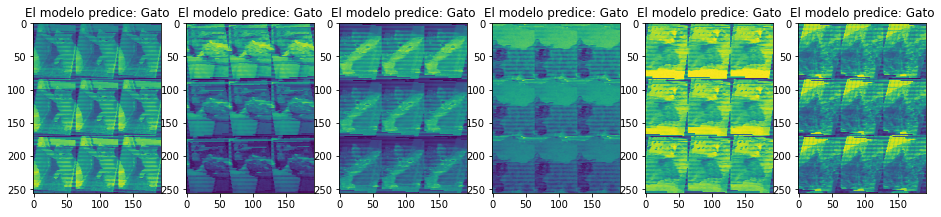

In [20]:
N = 6
fig, axs = plt.subplots(1,N,figsize=(16,8))
for i, (x, y) in enumerate(test_ds):
  if i == N:
    break
  x = x.reshape(1,3,128,128).to(dev)
  ypred = model(x)
  axs[i].imshow(x.cpu().reshape(256,192).numpy())
  axs[i].set_title(f"El modelo predice: {labels[torch.argmax(ypred)]}")

In [ ]:
torch.save(model.state_dict(),"proyecto1.ckpt")

# Proyecto 2: Detección de Objetos

Para este proyecto se utilizara [este dataset de fotos de autos con sus repectivos bounding boxes](https://www.kaggle.com/sshikamaru/car-object-detection).

El objetivo de este proyecto es el de poder entrenar una red neuronal (preentrenada) para poder detectar autos en una foto.

**[Optional]**

Si se desea, podrian crear su propia dataset con fotos que tomen ustedes mismos y definiendo los bounding boxes de los objetos dentro de la imagen

## Reporte

**Si se utiliza un dataset diferente, especificar el tipo de dataset**

In [ ]:
# No se necesita modificar, a menos que usen un dataset diferente
!kaggle datasets download sshikamaru/car-object-detection
!unzip car-object-detection.zip

 95% 106M/112M [00:02<00:00, 45.8MB/s] 
100% 112M/112M [00:02<00:00, 41.6MB/s]
Archive:  car-object-detection.zip
  inflating: data/sample_submission.csv  
  inflating: data/testing_images/vid_5_25100.jpg  
  inflating: data/testing_images/vid_5_25120.jpg  
  inflating: data/testing_images/vid_5_25140.jpg  
  inflating: data/testing_images/vid_5_25160.jpg  
  inflating: data/testing_images/vid_5_25180.jpg  
  inflating: data/testing_images/vid_5_25200.jpg  
  inflating: data/testing_images/vid_5_25220.jpg  
  inflating: data/testing_images/vid_5_25240.jpg  
  inflating: data/testing_images/vid_5_25260.jpg  
  inflating: data/testing_images/vid_5_26320.jpg  
  inflating: data/testing_images/vid_5_26400.jpg  
  inflating: data/testing_images/vid_5_26420.jpg  
  inflating: data/testing_images/vid_5_26560.jpg  
  inflating: data/testing_images/vid_5_26580.jpg  
  inflating: data/testing_images/vid_5_26600.jpg  
  inflating: data/testing_images/vid_5_26620.jpg  
  inflating: data/testing_im

**Si se utiliza un dataset diferente, explicar que tipos de cambios se realiza a esta clase**

In [ ]:
# Si se llega a utilizar un dataset diferente, se necesitara modificar
# esta clase acorde a la estructura de su dataset.
class MyDataset(torch.utils.data.Dataset):
  def __init__(self, transform=None):
    self.boxes_df = pd.read_csv("data/train_solution_bounding_boxes (1).csv")
    self.imgs = list(set(self.boxes_df.image))
    self.transform = transform
  def __getitem__(self, idx):
    img_ = self.imgs[idx]
    x = PIL.Image.open(os.path.join(f"data/training_images/{img_}"))
    if self.transform is not None:
      x = self.transform(x)
    boxes = torch.from_numpy(self.boxes_df.loc[self.boxes_df["image"]==img_].drop(columns=["image"]).to_numpy()).float()
    labels = torch.tensor([1]*len(boxes)).long()
    y = {"boxes": boxes, "labels": labels}
    return x, y
  def __len__(self):
    return len(self.imgs)

In [ ]:
# Esto no se necesita modificar, a menos que se quiera usar un batch size más grande
def collate_fn(batch):
    return tuple(zip(*batch))

train_ds = MyDataset(transform=torchvision.transforms.ToTensor())
train_dl = torch.utils.data.DataLoader(train_ds, batch_size=2,collate_fn=collate_fn)

**Explicar que cambios se realizo al modelo y porque**

In [ ]:
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

# TODO: Modificar el modelo

# MODIFICAR EL MODELO ACA

In [ ]:
from collections import defaultdict

optim = torch.optim.SGD(model.parameters(),lr=0.005, momentum=0.9)
model.train()

N = len(train_ds)
for epoch in range(10):
  l_dict = defaultdict(lambda : 0)
  for x, y in train_dl:
    x = [x_.to(dev) for x_ in x]
    targets = [{k:v.to(dev) for k,v in y_.items()} for y_ in y]
    losses = model(x,targets)
    for k,v in losses.items():
      l_dict[k] += v.item()
    loss = sum([l for l in  losses.values()])
    optim.zero_grad()
    loss.backward()
    optim.step()
  for k,v in l_dict.items():
    l_dict[k] /= N
  print(l_dict)

defaultdict(<function <lambda> at 0x7f6e69f4f830>, {'loss_classifier': 0.020267550096335546, 'loss_box_reg': 0.05149794012622934, 'loss_objectness': 0.0004558799355590067, 'loss_rpn_box_reg': 0.0010790233782731968})
defaultdict(<function <lambda> at 0x7f6e69f4fcb0>, {'loss_classifier': 0.014171767468288752, 'loss_box_reg': 0.039324128181791644, 'loss_objectness': 0.0002974539216153625, 'loss_rpn_box_reg': 0.001013886356258168})
defaultdict(<function <lambda> at 0x7f6e69f4f4d0>, {'loss_classifier': 0.013411749347152424, 'loss_box_reg': 0.03802716195793219, 'loss_objectness': 0.0002508832305542916, 'loss_rpn_box_reg': 0.0009724155090122916})
defaultdict(<function <lambda> at 0x7f6e69f4fcb0>, {'loss_classifier': 0.013168162801368555, 'loss_box_reg': 0.037134854857560615, 'loss_objectness': 0.0003194050117189632, 'loss_rpn_box_reg': 0.0009400796721743511})
defaultdict(<function <lambda> at 0x7f6e6ac65ef0>, {'loss_classifier': 0.013111096670405126, 'loss_box_reg': 0.036228681486886995, 'los

tensor([502.2579, 171.8672, 658.3138, 236.0870], grad_fn=<UnbindBackward0>)
tensor([347.0187, 183.6840, 465.4633, 229.5703], grad_fn=<UnbindBackward0>)


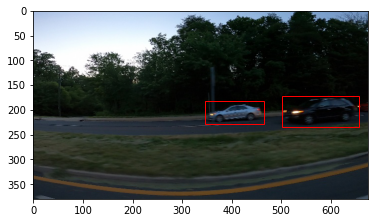

In [ ]:
# Esto no se necesita modificar, es solo para observar el performance del model
# frente a unas testing images

model.eval()
# img = 26580
# img = 26660
img = 26900
I = PIL.Image.open(open(f"./data/testing_images/vid_5_{img}.jpg","rb")).convert("RGB")
x = torchvision.transforms.ToTensor()(I)
x = x.reshape(1,*x.shape)
y = model(x.to(dev))
boxes = y[0]["boxes"].cpu()
labels =y[0]["labels"].cpu()
scores = y[0]["scores"].cpu()
numpy_x = x.numpy()
ax = plt.gca()
plt.imshow(numpy_x.reshape(numpy_x.shape[1:]).transpose(1,2,0))
for box,label,score in zip(boxes,labels,scores):
  if score > 0.8:
    print(box)
    x1, y1, x2, y2 = box.detach().numpy()
    rect = patches.Rectangle((int(x1),int(y1)),int(x2-x1),int(y2-y1),fill=False,color="#FF0000")
    ax.add_patch(rect)

In [ ]:
torch.save(model.state_dict(),"proyecto2.ckpt")

# Proyecto 3: Speech Recognition

Este proyecto consiste en entrenar una red neuronal para que pueda reconocer los camandos dados en los archivos de audio en [esta dataset](https://www.kaggle.com/tommyngx/fluent-speech-corpus)

**[OPTIONAL]**

Pueden crear sus propios dataset con su microfono. Por ejemplo: audio con diciendi ciertos comandos como: "apagar", "prender", etc.

## Reporte

**Modificar esto si se utiliza otra dataset, explicar el tipo de dataset**

In [ ]:
# Esto no se modifica a menos que se utilice otra dataset
!kaggle datasets download tommyngx/fluent-speech-corpus
!unzip fluent-speech-corpus.zip

Streaming output truncated to the last 5000 lines.
  inflating: fluent_speech_commands_dataset/wavs/speakers/oXjpaOq4wVUezb3x/e4858660-4510-11e9-9539-7f047cfe24d1.wav  
  inflating: fluent_speech_commands_dataset/wavs/speakers/oXjpaOq4wVUezb3x/e48a36c0-450f-11e9-9539-7f047cfe24d1.wav  
  inflating: fluent_speech_commands_dataset/wavs/speakers/oXjpaOq4wVUezb3x/e5cbd3f0-450e-11e9-9539-7f047cfe24d1.wav  
  inflating: fluent_speech_commands_dataset/wavs/speakers/oXjpaOq4wVUezb3x/e60046e0-450d-11e9-9539-7f047cfe24d1.wav  
  inflating: fluent_speech_commands_dataset/wavs/speakers/oXjpaOq4wVUezb3x/e6175480-4511-11e9-9539-7f047cfe24d1.wav  
  inflating: fluent_speech_commands_dataset/wavs/speakers/oXjpaOq4wVUezb3x/e67c9b70-4510-11e9-9539-7f047cfe24d1.wav  
  inflating: fluent_speech_commands_dataset/wavs/speakers/oXjpaOq4wVUezb3x/e6cc5e90-450f-11e9-9539-7f047cfe24d1.wav  
  inflating: fluent_speech_commands_dataset/wavs/speakers/oXjpaOq4wVUezb3x/e7980870-450e-11e9-9539-7f047cfe24d1.wav  
  inf

**Si se utiliza otra dataset, explicar como se debe cambiar esta clase**

In [ ]:
# Esto no se modifica a menos que se utilice otra dataset

class MyDataset(torch.utils.data.Dataset):
  def __init__(self,transform=None,train=True,list_transcription=None):
    self.wav_df = pd.read_csv(f"fluent_speech_commands_dataset/data/{'train' if train else 'test'}_data.csv")
    self.list_transcription = list_transcription
    if self.list_transcription is None:
      self.list_transcription = list(set(self.wav_df.transcription))
    self.dict_transcription = {k:v for v,k in enumerate(self.list_transcription)}
    self.transform = transform
    self.max_length = 30000

  def __getitem__(self,idx):
    _, x = wavfile.read(os.path.join("fluent_speech_commands_dataset",self.wav_df.path.iloc[idx]))
    x = torch.from_numpy(x)
    x = x/ 4000.0
    if self.transform is not None:
      x = self.transform(x)
    x = x[:self.max_length]
    N, = x.shape
    x = x.reshape(1,-1)
    x = torch.functional.F.pad(x,(0,(self.max_length - N)),mode="constant",value=0.0)
    y = self.dict_transcription[self.wav_df.transcription.iloc[idx]]
    return x, y 
  def __len__(self):
    return len(self.wav_df)

In [ ]:
# Esto no se modifica, a menos que se quiera utilizar un batch size diferente
audio_transform = torchaudio.transforms.Resample(new_freq=8000)

train_ds = MyDataset(transform=audio_transform)
test_ds = MyDataset(transform=audio_transform,train=False,list_transcription=train_ds.list_transcription)

train_dl = torch.utils.data.DataLoader(train_ds, batch_size=128,shuffle=True)
test_dl = torch.utils.data.DataLoader(test_ds, batch_size=128,shuffle=True)

**Si se modifica el codigo de la celda inferior, explicar los cambios que se hizo y porque**

In [ ]:
# Esto no se modifica a menos que se quiera almacenar los accuracy y loss para poder plotearlos luego.

def evaluate(model, loader, crit):
  model.eval()
  total = 0
  corrects = 0
  avg_loss = 0
  for x, y in loader:
    x = x.to(dev)
    y = y.to(dev)
    o = model(x)
    loss = crit(o,y)
    avg_loss += loss.item()
    corrects += torch.sum(torch.argmax(o,axis=1) == y).item()
    total += len(y)
  acc = 100* corrects / total
  avg_loss /= len(loader)  
  return avg_loss, acc

def train_one_epoch(model, train_loader, crit, optim):
  model.train()
  total = 0
  corrects = 0
  avg_loss = 0
  for x, y in train_loader:
    optim.zero_grad()
    x = x.to(dev)
    y = y.to(dev)
    o = model(x)
    loss = crit(o,y)
    avg_loss += loss.item()
    loss.backward()
    optim.step()
    corrects += torch.sum(torch.argmax(o,axis=1) == y).item()
    total += len(y)
  acc = 100 * corrects / total
  avg_loss /= len(train_loader)
  return avg_loss, acc

def train(model, train_loader, test_loader, crit, optim, epochs = 20):
  for epoch in range(epochs):
    train_loss, train_acc = train_one_epoch(model, train_loader,crit, optim)
    test_loss, test_acc = evaluate(model, test_loader, crit)
    print(f"epoch: {epoch}, train loss: {train_loss}, train acc: {train_acc}%, test loss: {test_loss}, test acc: {test_acc}%")

**Defina su modelo**

In [ ]:
# TODO: Definir el modelo
model = nn.Sequential(
  # DEFINIR LOS LAYERS
).to(dev)

In [ ]:
# Esto no se modifica 
# OPTIONAL:
# Cambie el learning rate o el optimizador y describa los cambios que se pudo apreciar durante el entrenamiento
crit = nn.CrossEntropyLoss()
optim = torch.optim.SGD(model.parameters(), lr=0.1)
train(model, train_dl, test_dl,crit,optim,epochs=10)

epoch: 0, train loss: 4.616668615551943, train acc: 6.8346878782638765%, test loss: 3.967135039965312, test acc: 12.44397574479304%
epoch: 1, train loss: 2.7668269740942435, train acc: 33.02784022133841%, test loss: 2.807505496342977, test acc: 31.241761138940152%
epoch: 2, train loss: 1.6919381519707526, train acc: 57.906795780736644%, test loss: 1.5007813215255736, test acc: 59.873451094120746%
epoch: 3, train loss: 1.1739902015549044, train acc: 70.0717620612139%, test loss: 2.538114309310913, test acc: 39.17743211178487%
epoch: 4, train loss: 0.8759684424373985, train acc: 77.84022133840567%, test loss: 1.0245067775249481, test acc: 71.50013182177696%
epoch: 5, train loss: 0.6801667628367303, train acc: 82.65606086806156%, test loss: 1.0795763850212097, test acc: 69.91827049828632%
epoch: 6, train loss: 0.5232052626860076, train acc: 87.24278056372125%, test loss: 0.9634583453337352, test acc: 73.0819931452676%
epoch: 7, train loss: 0.4195614766679416, train acc: 89.89278920975272%

In [ ]:
# Esto no se modifica, solo es para visualizar el performance del modelo
model.eval()
idx = 100
x_, y_ = test_ds[idx]
display(Audio(x_.numpy().reshape(-1),rate=8000))
x_ = x_.reshape(1,1,30000).to(dev)
pred = torch.argmax(model(x_).cpu()).item()
print(train_ds.list_transcription[pred])

I couldn't hear anything, turn up the volume


In [ ]:
torch.save(model.state_dict(),"proyecto3.ckpt")